In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import sklearn as sk
import sklearn.gaussian_process as gp
from datetime import timedelta as dt

In [167]:
df = pd.read_csv('sotonmet.txt')

Defining variables by indexing columns from DataFrame

In [168]:
t = df['Reading Date and Time (ISO)'] #time
y = df['Tide height (m)']   #Tide height reading
y_true = df['True tide height (m)'] #Ground truth tide heights

Plot of Tide Height (m) against DateTime (ISO)

In [169]:
# Convert t's elements from string to DateTime objects
t=t.apply(datetime.datetime.fromisoformat)

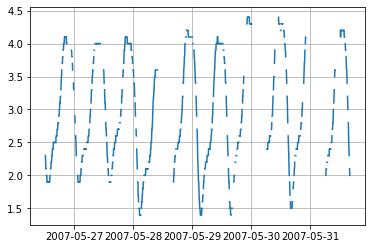

In [170]:
plt.plot(t,y)
plt.grid()

Tide Height displays periodicity as can be seen in plot above.

Start with Exponentiated Quadratic (no white kernel)

In [171]:
df['Reading Date and Time (ISO)']=df['Reading Date and Time (ISO)'].apply(datetime.datetime.fromisoformat)

In [172]:
df['Time'] = np.nan
df['Time'] = (df['Reading Date and Time (ISO)']-df['Reading Date and Time (ISO)'].iloc[0])
df['Time']=df['Time'].dt.total_seconds()

In [173]:
df_training=df.drop(df[df['Tide height (m)'].isnull()].index)
df_missing = df[df['Tide height (m)'].isnull()]

In [174]:
X = df_training[['Tide height (m)','Time']].to_numpy()
X_missing = df_missing['Time'].to_numpy()
X_GT=df_missing['True tide height (m)'].to_numpy()

In [175]:
x_training=X[:,0].reshape(-1,1)
t_training = X[:,1].reshape(-1,1)
X_GT = X_GT.reshape(-1,1)

In [176]:
t2=X_missing.reshape(-1,1)


In [374]:
kernel1=gp.kernels.RBF(length_scale=0.01,length_scale_bounds=(1e-7,1e8))

In [375]:
gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel1,n_restarts_optimizer=20)
gpr.fit(t_training,x_training)

GaussianProcessRegressor(kernel=RBF(length_scale=0.01), n_restarts_optimizer=20)

In [376]:
answer=gpr.predict(t2)

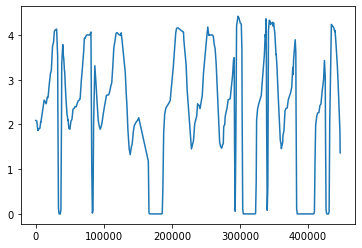

In [377]:
plt.plot(t2,answer)


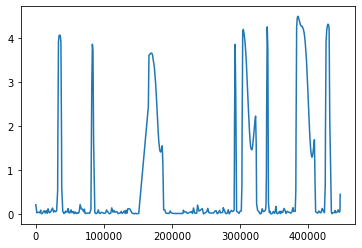

In [378]:
plt.plot(t2,abs(answer-X_GT))

In [379]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

In [380]:
df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

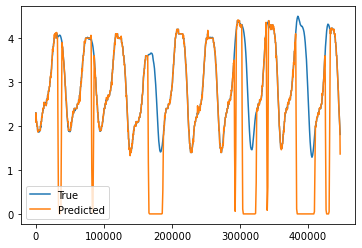

In [381]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()

In [382]:
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

1.7484734844496297


Exponentiated Quadratic with White Kernel

In [414]:
kernel2=gp.kernels.RBF(length_scale=0.01,length_scale_bounds=(1e-7,1e8)) + gp.kernels.WhiteKernel()

gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel2,n_restarts_optimizer=20)
gpr.fit(t_training,x_training)
answer=gpr.predict(t2)

In [415]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

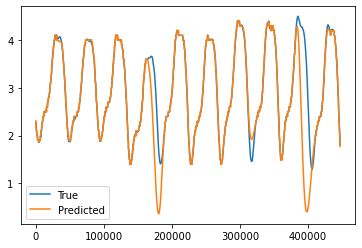

In [416]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()

In [417]:
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

0.6670948421731853


In [418]:
gpr.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': RBF(length_scale=0.01),
 'kernel__k2': WhiteKernel(noise_level=1),
 'kernel__k1__length_scale': 0.01,
 'kernel__k1__length_scale_bounds': (1e-07, 100000000.0),
 'kernel__k2__noise_level': 1.0,
 'kernel__k2__noise_level_bounds': (1e-05, 100000.0),
 'kernel': RBF(length_scale=0.01) + WhiteKernel(noise_level=1),
 'n_restarts_optimizer': 20,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

Including White Kernel seems to improve predictions.
We also know the training data likely differs from Ground Truth data due to sensor noise, so we can try applying the trained regressor to all data points.

In [396]:
answer=gpr.predict(df_index.index.to_numpy().reshape(-1,1))

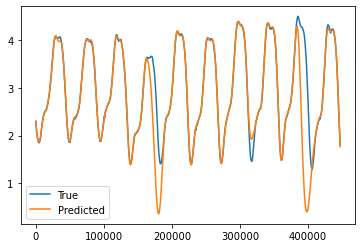

In [408]:
plt.plot(df_index.index.to_numpy().reshape(-1,1),y_true,label='True')
plt.plot(df_index.index,answer,label='Predicted')
plt.legend()

In [411]:
rms_error = np.sqrt(np.average(np.square(answer-y_true.to_numpy().reshape(-1,1))))
print(rms_error)

0.34758293078218316


RBF + White Kernel seems effective at predicting in the presence of sensor noise

Since data displays periodicity, try Exp-Sine-Squared Kernel (periodic kernel) with no White Kernel

In [412]:
kernel3=gp.kernels.ExpSineSquared() + gp.kernels.WhiteKernel()

In [413]:
gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel3,n_restarts_optimizer=10)
gpr.fit(t_training,x_training)

GaussianProcessRegressor(kernel=ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [308]:
answer=gpr.predict(t2)

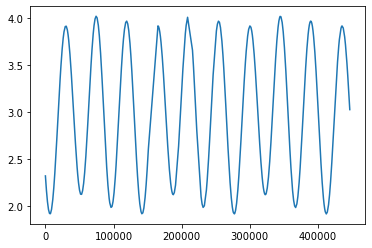

In [309]:
plt.plot(t2,answer)


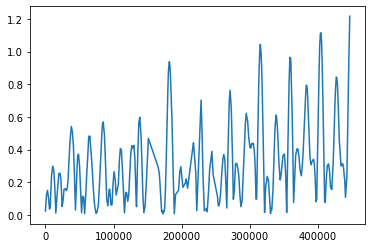

In [310]:
plt.plot(t2,abs(answer-X_GT))

In [311]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B

In [312]:
df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

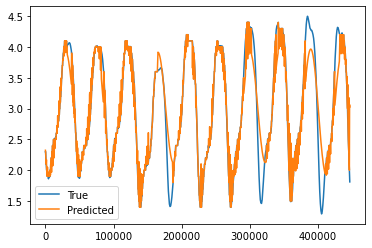

In [313]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()

In [314]:
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': ExpSineSquared(length_scale=1, periodicity=1),
 'kernel__k2': WhiteKernel(noise_level=1),
 'kernel__k1__length_scale': 1.0,
 'kernel__k1__periodicity': 1.0,
 'kernel__k1__length_scale_bounds': (1e-05, 100000.0),
 'kernel__k1__periodicity_bounds': (1e-05, 100000.0),
 'kernel__k2__noise_level': 1.0,
 'kernel__k2__noise_level_bounds': (1e-05, 100000.0),
 'kernel': ExpSineSquared(length_scale=1, periodicity=1) + WhiteKernel(noise_level=1),
 'n_restarts_optimizer': 10,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [350]:
kernel4=gp.kernels.ExpSineSquared() + gp.kernels.WhiteKernel()

gpr=gp.GaussianProcessRegressor(normalize_y=False,kernel=kernel4,n_restarts_optimizer=10)
gpr.fit(t_training,x_training)
answer=gpr.predict(t2)


/Users/terencetan/opt/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [351]:
d1={}
for A,B in zip(np.reshape(t2,-1),np.reshape(answer,-1)):
    d1[A]=B

d2={}
for A,B in zip(np.reshape(t2,-1),np.reshape(X_GT,-1)):
    d2[A]=B


df_index = df.set_index('Time')
df_predicted=df_index['Tide height (m)'].fillna(d1)
df_actual=df_index['Tide height (m)'].fillna(d2)

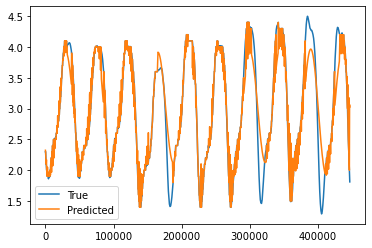

In [356]:
plt.plot(df_actual.index,df_actual,label='True')
plt.plot(df_predicted.index,df_predicted,label='Predicted')
plt.legend()

In [369]:
# Root Mean Square Error
rms_error = np.sqrt(np.average(np.square(answer-X_GT)))
print(rms_error)

0.4332071684623606


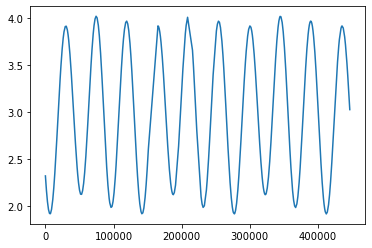

In [354]:
plt.plot(t2,answer)


In [359]:
df_actual

Time
0.0         2.30
300.0       2.30
600.0       2.20
900.0       2.10
1200.0      2.10
            ... 
445800.0    2.19
446100.0    2.10
446400.0    2.00
446700.0    1.90
447000.0    1.81
Name: Tide height (m), Length: 1258, dtype: float64

In [360]:
df_predicted

Time
0.0         2.323172
300.0       2.300000
600.0       2.200000
900.0       2.100000
1200.0      2.100000
              ...   
445800.0    3.175985
446100.0    2.100000
446400.0    2.000000
446700.0    3.064380
447000.0    3.026926
Name: Tide height (m), Length: 1258, dtype: float64

In [419]:
x=[1,2,5,4]

In [424]:
x.sort(reverse=True)

In [425]:
x

[5, 4, 2, 1]

In [423]:
x[1]

2